# BEAM - Direct Probing Task Evaluation

This notebook analyzes the performance of a large language model (LLM) that has been probed to identify the **book title** and **author name** based on a passage from the book. The goal of this analysis is to determine whether the model's predictions are an **exact or fuzzy match** for the correct book title and author name.

## Dataset Overview
The dataset used in this analysis contains the following key fields:
- **Passage**: A snippet from a book that serves as input for the LLM.
- **Predicted Title**: The title predicted by the LLM.
- **Predicted Author**: The author predicted by the LLM.

## Workflow Outline
This notebook will perform the following steps:

1. **Data Loading**: 
   - Import the CSV containing LLM predictions and true values using `pandas`. 
   - Data integrity checks will be conducted to ensure there are no missing or unexpected values in the predicted columns.

2. **Exact Match Checking**: 
   - Compare predicted titles and authors with their corresponding actual values to determine correctness.
   - Use the `fuzzywuzzy` library to compute both exact and fuzzy match ratios for titles and authors.
   - Establish a threshold to classify predictions as correct or incorrect.

3. **Result Analysis**: 
   - Calculate metrics such as accuracy for each language, as well as overall performance metrics.
   - Aggregate the results to determine the percentage of correct predictions for titles and authors.

4. **Visualization**: 
   - Create bar graphs to visualize the percentage accuracy of predicted titles and authors for each language.
   - Display the results using `Matplotlib` and `Seaborn` for clear and informative visual presentations.

## Tools and Libraries
We will be using the following libraries for this analysis:
- **Pandas**: For data manipulation and analysis, including reading CSV files and handling DataFrames.
- **Numpy**: For numerical operations and array manipulations.
- **Matplotlib** and **Seaborn**: For data visualization, enabling the creation of informative plots to communicate results effectively.
- **FuzzyWuzzy**: For fuzzy string matching, allowing the evaluation of predictions even when they are not exact matches.

This analysis will help us better understand the model's performance in recognizing book titles and authors based on textual passages, highlighting areas for improvement and guiding further development.

In [91]:
import pandas as pd
import unidecode
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt



In [92]:
df = pd.read_csv('/Users/alishasrivastava/BEAM/scripts/direct_probing/results/Adventures_of_Huckleberry_Finn_direct-probe_gpt4o.csv')
df.drop(columns=['en_title', 'en_author', 'es_title', 'es_author', 'tr_title', 'tr_author', 'vi_title', 'vi_author'], inplace=True)

### Creating columns for predicted author and title

In [93]:
def extract_title_author(results_column):
    results_column = results_column.fillna('').astype(str).str.strip()
    return results_column.str.extract(r'"title":\s*"(.*?)",\s*"author":\s*"(.*?)"')

for language in df.columns:
    if '_results' in language:
        print(f'Running extraction for {language}')
        
        extracted_titles_authors = extract_title_author(df[language])
        language_suffix = language.replace('_results', '')
        
        df[f'{language_suffix}_predicted_title'] = extracted_titles_authors[0]
        df[f'{language_suffix}_predicted_author'] = extracted_titles_authors[1]

Running extraction for en_results
Running extraction for es_results
Running extraction for tr_results
Running extraction for vi_results


## Data Integrity Check

The following function `check_data_integrity` is designed to validate the integrity of predicted titles and authors for multiple languages (`en`, `es`, `tr`, `vi`). It performs the following checks:

1. **NaN Values**: Checks if any missing (`NaN`) values exist in the columns for predicted titles and authors for a given language.
2. **Unexpected Empty Values**: Verifies if there are any unexpected empty strings (`''`) in the predicted titles or authors, which may indicate incomplete data.

In [109]:
def check_data_integrity(language):
    print(f"\nChecking integrity for language: {language}")
    predicted_titles = df[f'{language}_predicted_title']
    predicted_authors = df[f'{language}_predicted_author']
    
    if predicted_titles.isnull().any():
        print(f"NaN values found in {language}_predicted_title:")
        print(predicted_titles[predicted_titles.isnull()])
    else:
        print(f"No NaN in {language}_predicted_title")

    if predicted_authors.isnull().any():
        print(f"NaN values found in {language}_predicted_author:")
        print(predicted_authors[predicted_authors.isnull()])
    else:
        print(f"No NaN values in {language}_predicted_author")

    unexpected_titles = predicted_titles[predicted_titles.str.strip() == '']
    if not unexpected_titles.empty:
        print(f"Unexpected empty values in {language}_predicted_title:")
        print(unexpected_titles)
    else:
        print(f"No unexpected empty values in {language}_predicted_title")

    unexpected_authors = predicted_authors[predicted_authors.str.strip() == '']
    if not unexpected_authors.empty:
        print(f"Unexpected empty values in {language}_predicted_author:")
        print(unexpected_authors)
    else:
        print(f"No unexpected empty values in {language}_predicted_author")

for language in ['en', 'es', 'tr', 'vi']: 
    check_data_integrity(language)


Checking integrity for language: en
No NaN in en_predicted_title
No NaN values in en_predicted_author
No unexpected empty values in en_predicted_title
No unexpected empty values in en_predicted_author

Checking integrity for language: es
No NaN in es_predicted_title
No NaN values in es_predicted_author
No unexpected empty values in es_predicted_title
No unexpected empty values in es_predicted_author

Checking integrity for language: tr
No NaN in tr_predicted_title
No NaN values in tr_predicted_author
No unexpected empty values in tr_predicted_title
No unexpected empty values in tr_predicted_author

Checking integrity for language: vi
No NaN in vi_predicted_title
No NaN values in vi_predicted_author
No unexpected empty values in vi_predicted_title
No unexpected empty values in vi_predicted_author


## Fuzzy Matching and Exact Matching with FuzzyWuzzy

In this section, we implement a method to evaluate the predicted titles and authors using both exact matching and fuzzy matching techniques. The `fuzzywuzzy` library calculates string similarity scores using Levenshtein Distance, allowing us to assess how closely the predicted values match the ground-truth values.

### Steps:
1. **Exact Matching**: We check if the predicted title or author matches the actual title or author exactly. This is done by comparing the cleaned (unidecoded) versions of the strings and returning `1` for a match and `0` for no match.
  
2. **Fuzzy Matching**: We use the `fuzz.ratio` method from the `fuzzywuzzy` library to calculate the similarity score between the predicted and actual titles or authors. This score ranges from `0` to `100`, with `100` indicating an exact match.


In [110]:
book_data = {
    'en': ["The Adventures of Huckleberry Finn"],
    'es': ["Las aventuras de Huckleberry Finn", "The Adventures of Huckleberry Finn"],
    'tr': ["The Adventures of Huckleberry Finn", "Huckleberry Finn'in Maceralari"],
    'vi': ["The Adventures of Huckleberry Finn", "cuoc phieu luu cua huckleberry finn"]
}
book_authors = {
    'en': ["Mark Twain", "Twain", "Mark"],
    'es': ["Mark Twain", "Twain", "Mark"],
    'tr': ["Mark Twain", "Twain", "Mark"],
    'vi': ["Mark Twain", "Twain", "Mark"]
}
    
for language in ['en', 'es', 'tr', 'vi']:
    actual_titles = book_data[language]
    actual_authors = book_authors[language]
    
    # Exact match scores for titles
    df[f'{language}_exact_match_title'] = df[f'{language}_predicted_title'].apply(
        lambda x: fuzz.ratio(unidecode.unidecode(x), unidecode.unidecode(actual_titles[0])) == 100
    ).astype(int)  # 1 for match, 0 for no match

    # Fuzzy match scores for titles
    df[f'{language}_fuzzy_match_title'] = df[f'{language}_predicted_title'].apply(
        lambda x: fuzz.ratio(unidecode.unidecode(x), unidecode.unidecode(actual_titles[0]))
    )

    # Exact match scores for authors
    df[f'{language}_exact_match_author'] = df[f'{language}_predicted_author'].apply(
        lambda x: fuzz.ratio(unidecode.unidecode(x), unidecode.unidecode(actual_authors[0])) == 100
    ).astype(int)  # 1 for match, 0 for no match

    # Fuzzy match scores for authors
    df[f'{language}_fuzzy_match_author'] = df[f'{language}_predicted_author'].apply(
        lambda x: fuzz.ratio(unidecode.unidecode(x), unidecode.unidecode(actual_authors[0]))
    )

## Fuzzy to Exact Match Ratio Calculation and Final Correctness Evaluation

In this section, we enhance our evaluation process by calculating the ratio of fuzzy match scores to exact match scores for both titles and authors across multiple languages. This approach allows us to assess the reliability of our predictions more effectively. Additionally, we establish a final correctness indicator that summarizes whether both title and author predictions are accurate.

### Steps:

1. **Threshold Definition**:
   - A threshold is established to determine correctness. In this implementation, a threshold of `1.0` is used.

2. **Fuzzy to Exact Ratio Calculation**:
   - For each language, we compute the ratio of the fuzzy match score to the exact match score for both titles and authors. This is accomplished by dividing the fuzzy match scores by the corresponding exact match scores. To handle potential division by zero errors, any infinite ratios are replaced with `0`.

3. **Correctness Evaluation**:
   - New columns are added to the DataFrame to indicate whether each title and author match is "correct" or "incorrect." This determination is based on whether the calculated ratio meets or exceeds the defined threshold:
     - If the ratio is greater than or equal to the threshold, the entry is labeled as "correct."
     - If the ratio is below the threshold, the entry is labeled as "incorrect."

4. **Final Correctness Evaluation**:
   - A final correctness column is added to indicate whether both the title and author are considered "correct." If both are correct, this entry is labeled as "correct"; otherwise, it is labeled as "incorrect."


In [111]:
threshold = 1.0  

for language in ['en', 'es', 'tr', 'vi']:
    # Calculating the ratio of fuzzy match to exact match for titles
    df[f'{language}_fuzzy_to_exact_title_ratio'] = (
        df[f'{language}_fuzzy_match_title'] / df[f'{language}_exact_match_title']
    ).replace([float('inf'), -float('inf')], 0)  # Replace infinite ratios with 0

    df[f'{language}_title_correct'] = df[f'{language}_fuzzy_to_exact_title_ratio'].apply(
        lambda x: 'correct' if x >= threshold else 'incorrect'
    )

    # Calculating the ratio of fuzzy match to exact match for authors
    df[f'{language}_fuzzy_to_exact_author_ratio'] = (
        df[f'{language}_fuzzy_match_author'] / df[f'{language}_exact_match_author']
    ).replace([float('inf'), -float('inf')], 0)  # Replace infinite ratios with 0

    df[f'{language}_author_correct'] = df[f'{language}_fuzzy_to_exact_author_ratio'].apply(
        lambda x: 'correct' if x >= threshold else 'incorrect'
    )

    # Final correctness evaluation, if author = correct & title = correct, final eval = correct
    df[f'{language}_prediction_correct'] = df.apply(
        lambda row: 'correct' if row[f'{language}_title_correct'] == 'correct' and row[f'{language}_author_correct'] == 'correct' else 'incorrect',
        axis=1
    )

## Author Accuracy Visualization

In this section, we present a bar graph depicting the accuracy of the large language model (LLM) in predicting authors across different languages. The accuracy is calculated based on the proportion of correct predictions relative to the total number of observations for each language.


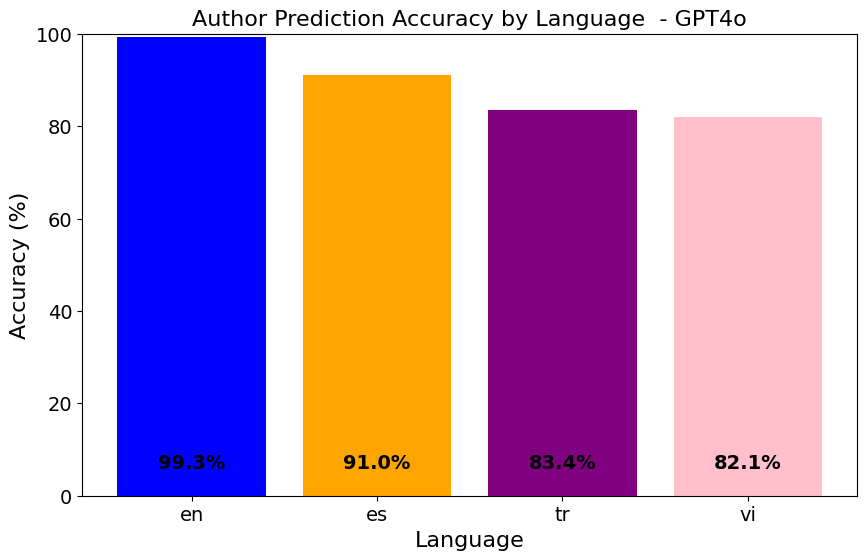

In [112]:
total_observations = len(df)
author_accuracy = {
    'en': df['en_author_correct'].value_counts(normalize=True)['correct'] * 100,
    'es': df['es_author_correct'].value_counts(normalize=True)['correct'] * 100,
    'tr': df['tr_author_correct'].value_counts(normalize=True)['correct'] * 100,
    'vi': df['vi_author_correct'].value_counts(normalize=True)['correct'] * 100
}
languages = list(author_accuracy.keys())
accuracy_values = list(author_accuracy.values())
plt.figure(figsize=(10, 6))
bars = plt.bar(languages, accuracy_values, color=['blue', 'green', 'red', 'purple'])

plt.bar(languages, accuracy_values, color=['blue', 'orange', 'purple', 'pink'])
plt.rcParams.update({'font.size': 14}) 

plt.xlabel('Language', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=16)
plt.title('Author Prediction Accuracy by Language  - GPT4o', fontsize=16)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 5, f'{height:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')  # Bold formatting added here

plt.ylim(0, 100)
plt.show()

## Title Accuracy Visualization

This section provides a bar graph that visualizes the accuracy of the large language model (LLM) in predicting book titles across different languages. The accuracy is determined by calculating the proportion of correct title predictions compared to the total number of observations for each language.

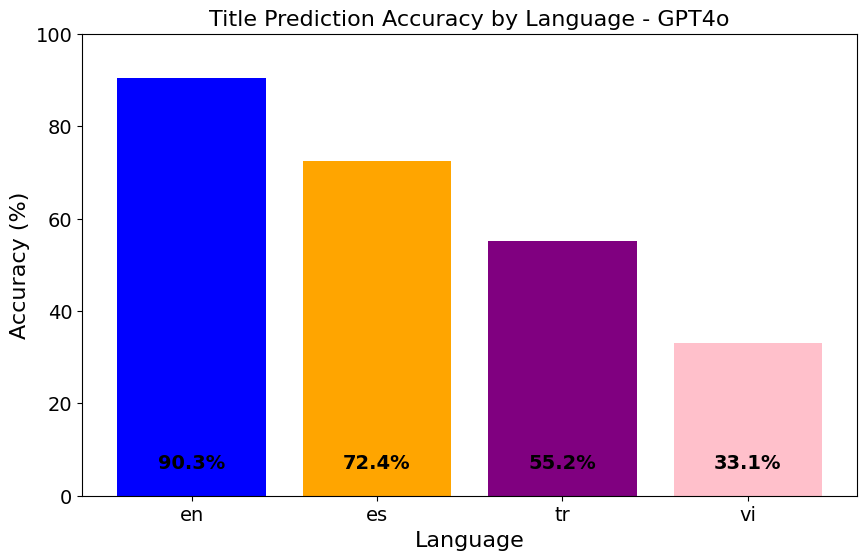

In [113]:
total_observations = len(df)
author_accuracy = {
    'en': df['en_title_correct'].value_counts(normalize=True)['correct'] * 100,
    'es': df['es_title_correct'].value_counts(normalize=True)['correct'] * 100,
    'tr': df['tr_title_correct'].value_counts(normalize=True)['correct'] * 100,
    'vi': df['vi_title_correct'].value_counts(normalize=True)['correct'] * 100
}

languages = list(author_accuracy.keys())
accuracy_values = list(author_accuracy.values())
plt.figure(figsize=(10, 6))
bars = plt.bar(languages, accuracy_values, color=['blue', 'green', 'red', 'purple'])

plt.bar(languages, accuracy_values, color=['blue', 'orange', 'purple', 'pink'])
plt.rcParams.update({'font.size': 14}) 

plt.xlabel('Language', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=16)
plt.title('Title Prediction Accuracy by Language - GPT4o', fontsize=16)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 5, f'{height:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')  # Bold formatting added here

plt.ylim(0, 100)
plt.show()


## Overall Prediction Accuracy Visualization

This section provides a bar graph that visualizes the overall accuracy of the large language model (LLM) in predicting both book titles and authors across different languages. The overall accuracy is determined by checking if both the title and author predictions are correct for a given observation.

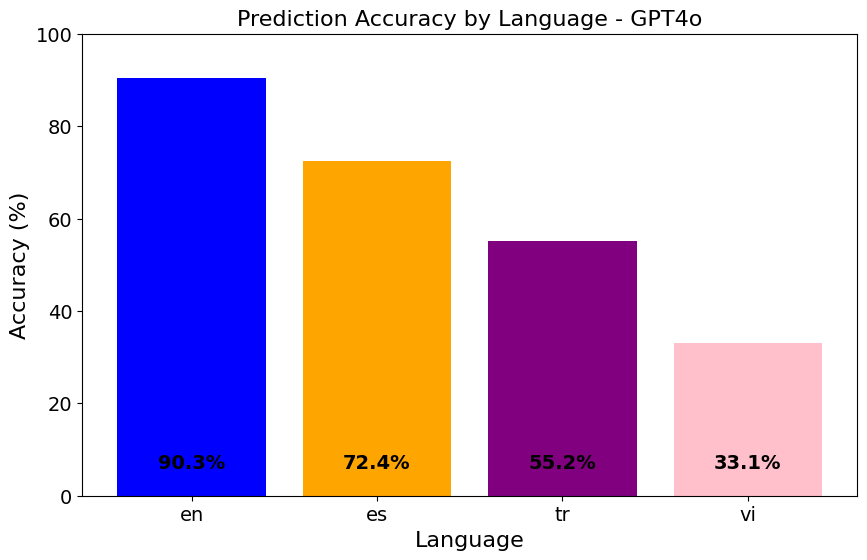

In [114]:
total_observations = len(df)
author_accuracy = {
    'en': df['en_prediction_correct'].value_counts(normalize=True)['correct'] * 100,
    'es': df['es_prediction_correct'].value_counts(normalize=True)['correct'] * 100,
    'tr': df['tr_prediction_correct'].value_counts(normalize=True)['correct'] * 100,
    'vi': df['vi_prediction_correct'].value_counts(normalize=True)['correct'] * 100
}

languages = list(author_accuracy.keys())
accuracy_values = list(author_accuracy.values())
plt.figure(figsize=(10, 6))
bars = plt.bar(languages, accuracy_values, color=['blue', 'green', 'red', 'purple'])

plt.bar(languages, accuracy_values, color=['blue', 'orange', 'purple', 'pink'])
plt.rcParams.update({'font.size': 14}) 

plt.xlabel('Language', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=16)
plt.title('Prediction Accuracy by Language - GPT4o', fontsize=16)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 5, f'{height:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')  # Bold formatting added here

plt.ylim(0, 100)
plt.show()


In [115]:
df.to_csv('overall_prediction_results.csv', index=False)